In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!tar -xvf "/content/drive/My Drive/AMLT/lfw.tgz"

# Loading the data

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import imageio
from PIL import Image
import os
import glob
import random
import warnings

from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')
main_path = '/content/lfw'
people = os.listdir(main_path)

d = []
for path in glob.iglob(os.path.join(main_path, "**")):
    person = path.split("/")[-1]
    d.append({"person":person, "files": os.listdir(path), 'path': path})
df = pd.DataFrame(d)
df

,person,files,path
0,Jeremy_Fogel,[Jeremy_Fogel_0001.jpg],/content/lfw/Jeremy_Fogel
1,Paulie_Ayala,[Paulie_Ayala_0001.jpg],/content/lfw/Paulie_Ayala
2,Teresa_Worbis,[Teresa_Worbis_0001.jpg],/content/lfw/Teresa_Worbis
3,Gerald_Riley,[Gerald_Riley_0001.jpg],/content/lfw/Gerald_Riley
4,Darren_Campel,[Darren_Campel_0001.jpg],/content/lfw/Darren_Campel
...,...,...,...
5744,Chris_Claiborne,[Chris_Claiborne_0001.jpg],/content/lfw/Chris_Claiborne
5745,Eve_Pelletier,"[Eve_Pelletier_0001.jpg, Eve_Pelletier_0002.jpg]",/content/lfw/Eve_Pelletier
5746,Michael_Capellas,"[Michael_Capellas_0001.jpg, Michael_Capellas_0...",/content/lfw/Michael_Capellas
5747,Scott_Wallach,[Scott_Wallach_0001.jpg],/content/lfw/Scott_Wallach


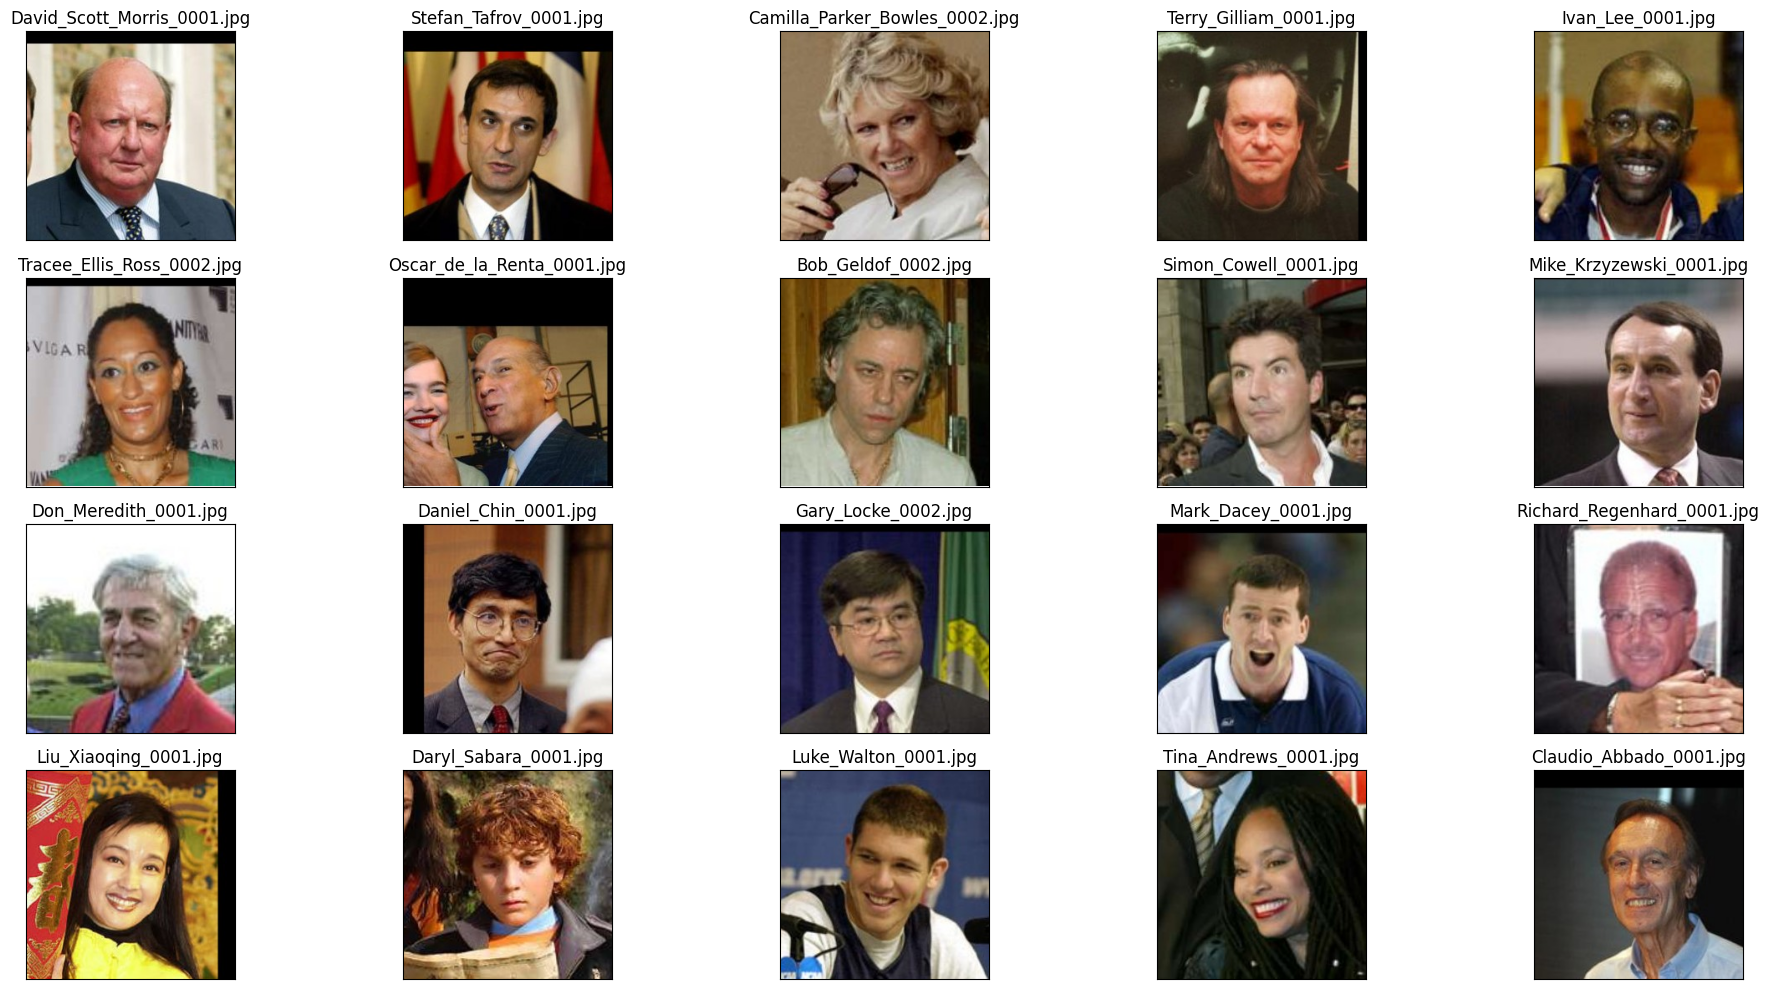

In [4]:
plt.figure(figsize=(20,10))
for i in range(20):
    idx = random.randint(0, len(df))
    img = plt.imread(os.path.join(df.path.iloc[idx],df.files.iloc[idx][0]))
    plt.subplot(4, 5, i+1)
    plt.imshow(img)
    plt.title(df.files.iloc[idx][0])
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

In [5]:
def data_preparation(dx=80, dy=80, dimx=45, dimy=45, beard = False, not_beard=False):
  attr = pd.read_csv('/content/drive/My Drive/AMLT/lfw_attributes.txt', sep='\t', skiprows=1)
  attr = pd.DataFrame(attr.iloc[:,:-1].values, columns = attr.columns[1:])
  attr = attr.rename({'No Beard': 'No_Beard'}, axis =1)
  photo_ids = []
  ids=0
  for dirpath, dirnames, filenames in os.walk(main_path):
      for fname in filenames:
          if fname.endswith(".jpg"):
              fpath = os.path.join(dirpath,fname)
              photo_id = fname[:-4].replace('_',' ').split() #replace '.' in '.jpg' to split by '_'
              person_id = ' '.join(photo_id[:-1]) #getting a str instead of a list
              photo_number = int(photo_id[-1])
              photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})
  photo_ids = pd.DataFrame(photo_ids)
  if beard == True:
    b=-2
    m=0.5
    attr = attr.query('(Male>0) and ((Mustache>@m) or (No_Beard<@b)) and (Smiling>0)')
    ids = attr.index.values
  if not_beard == True:
    b=-2
    m=0.5
    attr = attr.query('(Male>0) and ((Mustache<@m) or (No_Beard>@b)) and (Smiling<0)')
    ids = attr.index.values
  meta = pd.merge(attr,photo_ids,on=('person','imagenum'))
  #reading and resizing of the images
  photos = meta['photo_path'].apply(imageio.imread)\
                                .apply(lambda img: img[dy:-dy,dx:-dx])\
                                .apply(lambda img: np.array(Image.fromarray(img).resize([dimx,dimy])))
  photos = np.stack(photos.values).astype('uint8') #converting to 8-bit var (0-255)
  meta = meta.drop(["photo_path","person","imagenum"],axis=1)
  return meta, photos, ids

In [6]:
attr, data, _ = data_preparation()

In [7]:
IMAGE_H = data.shape[1]
IMAGE_W = data.shape[2]

N_CHANNELS = 3

data = np.array(data / 255, dtype='float32')
X_train, X_val = train_test_split(data, test_size=0.2, random_state=42)

X_train = torch.FloatTensor(X_train)
X_val = torch.FloatTensor(X_val)

# VAE

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
dim_z=500

In [27]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(45*45*3, 4500)
        self.fc2 = nn.Linear(4500, 2500)
        self.fc3 = nn.Linear(2500, 1500)
        self.fc21 = nn.Linear(1500, dim_z)
        self.fc22 = nn.Linear(1500, dim_z)
        self.fc4 = nn.Linear(dim_z, 1500)
        self.fc5= nn.Linear(1500, 2000)
        self.fc6 = nn.Linear(2000, 5500)
        self.fc7 = nn.Linear(5500, 45*45*3)

        self.relu = nn.LeakyReLU()

    def encode(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        return self.fc21(x), self.fc22(x)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 *logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)

    def decode(self, z):
        z = self.relu(self.fc4(z))
        z = self.relu(self.fc5(z))
        z = self.relu(self.fc6(z))
        return torch.sigmoid(self.fc7(z))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        z = self.decode(z)
        return z, mu, logvar

def loss_vae_fn(x, recon_x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [28]:
DEVICE='cuda'
model_vae = VAE().to(DEVICE)

# Training


In [16]:
from tqdm import tqdm

def get_batch(data, batch_size=64):
    total_len = data.shape[0]
    for i in range(0, total_len, batch_size):
        yield data[i:min(i+batch_size,total_len)]
def plot_gallery(images, h, w, n_row=3, n_col=6, with_title=False, titles=[]):
    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        try:
            plt.imshow(images[i].reshape((h, w, 3)), cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
            if with_title:
                plt.title(titles[i])
            plt.xticks(())
            plt.yticks(())
        except:
            pass
def fit_epoch_vae(model, train_x, optimizer, batch_size, is_cnn=False):
    running_loss = 0.0
    processed_data = 0

    for inputs in get_batch(train_x,batch_size):
        inputs = inputs.view(-1, 45*45*3)
        inputs = inputs.to(DEVICE)
        optimizer.zero_grad()

        decoded,mu,logvar, = model(inputs)
        outputs = decoded.view(-1, 45*45*3)
        outputs = outputs.to(DEVICE)

        loss = loss_vae_fn(inputs,outputs,mu,logvar)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.shape[0]
        processed_data += inputs.shape[0]

    train_loss = running_loss / processed_data
    return train_loss

def eval_epoch_vae(model, x_val, batch_size):
    running_loss = 0.0
    processed_data = 0
    model.eval()

    for inputs in get_batch(x_val,batch_size=batch_size):
        inputs = inputs.view(-1, 45*45*3)
        inputs = inputs.to(DEVICE)

        with torch.set_grad_enabled(False):
            decoded,mu,logvar = model(inputs)
            outputs = decoded.view(-1, 45*45*3)
            loss = loss_vae_fn(inputs,outputs,mu,logvar)
            running_loss += loss.item() * inputs.shape[0]
            processed_data += inputs.shape[0]

    val_loss = running_loss / processed_data

#draw
    with torch.set_grad_enabled(False):
        pic = x_val[3]
        pic_input = pic.view(-1, 45*45*3)
        pic_input = pic_input.to(DEVICE)
        decoded,mu,logvar = model(inputs)
        pic_output = decoded[0].view(-1, 45*45*3).squeeze()
        pic_output = pic_output.to("cpu")
        pic_input = pic_input.to("cpu")
        plot_gallery([pic_input, pic_output],45,45,1,2)

    return val_loss

def train_vae(train_x, val_x, model, epochs=10, batch_size=32, lr=0.001):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} val_loss: {val_loss:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        for epoch in range(epochs):
            train_loss = fit_epoch_vae(model,train_x,optimizer,batch_size)
            val_loss = eval_epoch_vae(model,val_x,batch_size)
            print("loss: ", train_loss)

            history.append((train_loss,val_loss))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss, val_loss=val_loss))

    return history

epoch:   2%|▏         | 1/50 [00:03<03:12,  3.94s/it]

loss:  615215.9003248644

Epoch 001 train_loss: 615215.9003 val_loss: 508715.1161


epoch:   4%|▍         | 2/50 [00:07<03:07,  3.91s/it]

loss:  516140.14404454775

Epoch 002 train_loss: 516140.1440 val_loss: 509688.8351


epoch:   6%|▌         | 3/50 [00:12<03:09,  4.03s/it]

loss:  511960.3357978053

Epoch 003 train_loss: 511960.3358 val_loss: 512260.2840


epoch:   8%|▊         | 4/50 [00:15<03:03,  3.98s/it]

loss:  508921.3837561822

Epoch 004 train_loss: 508921.3838 val_loss: 499007.3968


epoch:  10%|█         | 5/50 [00:19<02:58,  3.96s/it]

loss:  503381.5208531482

Epoch 005 train_loss: 503381.5209 val_loss: 500953.1936


epoch:  12%|█▏        | 6/50 [00:23<02:54,  3.96s/it]

loss:  502201.57467127166

Epoch 006 train_loss: 502201.5747 val_loss: 495071.0390


epoch:  14%|█▍        | 7/50 [00:27<02:49,  3.95s/it]

loss:  497239.5184738801

Epoch 007 train_loss: 497239.5185 val_loss: 491214.9741


epoch:  16%|█▌        | 8/50 [00:31<02:45,  3.94s/it]

loss:  496272.2199849605

Epoch 008 train_loss: 496272.2200 val_loss: 492266.9444


epoch:  18%|█▊        | 9/50 [00:35<02:41,  3.94s/it]

loss:  496207.543242938

Epoch 009 train_loss: 496207.5432 val_loss: 490389.7171


epoch:  20%|██        | 10/50 [00:39<02:37,  3.95s/it]

loss:  495598.92712543986

Epoch 010 train_loss: 495598.9271 val_loss: 490357.9917


epoch:  22%|██▏       | 11/50 [00:43<02:33,  3.94s/it]

loss:  495248.5903542301

Epoch 011 train_loss: 495248.5904 val_loss: 490002.7249


epoch:  24%|██▍       | 12/50 [00:47<02:29,  3.94s/it]

loss:  493790.44601840404

Epoch 012 train_loss: 493790.4460 val_loss: 488594.4338


epoch:  26%|██▌       | 13/50 [00:51<02:26,  3.96s/it]

loss:  492097.8679662236

Epoch 013 train_loss: 492097.8680 val_loss: 486746.8588


epoch:  28%|██▊       | 14/50 [00:55<02:22,  3.96s/it]

loss:  491823.56494911545

Epoch 014 train_loss: 491823.5649 val_loss: 487541.7634


epoch:  30%|███       | 15/50 [00:59<02:18,  3.96s/it]

loss:  491667.3142610448

Epoch 015 train_loss: 491667.3143 val_loss: 486813.5445


epoch:  32%|███▏      | 16/50 [01:03<02:14,  3.96s/it]

loss:  491395.94279353716

Epoch 016 train_loss: 491395.9428 val_loss: 486510.8119


epoch:  34%|███▍      | 17/50 [01:07<02:11,  3.98s/it]

loss:  491291.5472093756

Epoch 017 train_loss: 491291.5472 val_loss: 486915.8131


epoch:  36%|███▌      | 18/50 [01:11<02:07,  3.98s/it]

loss:  491353.6504571286

Epoch 018 train_loss: 491353.6505 val_loss: 486400.5177


epoch:  38%|███▊      | 19/50 [01:15<02:03,  3.98s/it]

loss:  491219.80488366704

Epoch 019 train_loss: 491219.8049 val_loss: 486290.2940


epoch:  40%|████      | 20/50 [01:19<02:01,  4.04s/it]

loss:  491174.7287886984

Epoch 020 train_loss: 491174.7288 val_loss: 486493.8304


epoch:  42%|████▏     | 21/50 [01:23<01:56,  4.03s/it]

loss:  491026.13910767785

Epoch 021 train_loss: 491026.1391 val_loss: 489717.6682


epoch:  44%|████▍     | 22/50 [01:27<01:52,  4.02s/it]

loss:  491550.8565573283

Epoch 022 train_loss: 491550.8566 val_loss: 486155.1397


epoch:  46%|████▌     | 23/50 [01:31<01:48,  4.02s/it]

loss:  490915.50887655746

Epoch 023 train_loss: 490915.5089 val_loss: 487588.4208


epoch:  48%|████▊     | 24/50 [01:35<01:46,  4.09s/it]

loss:  490998.1493380849

Epoch 024 train_loss: 490998.1493 val_loss: 485967.2456


epoch:  50%|█████     | 25/50 [01:39<01:41,  4.06s/it]

loss:  490914.54042229406

Epoch 025 train_loss: 490914.5404 val_loss: 487959.1286


epoch:  52%|█████▏    | 26/50 [01:43<01:37,  4.05s/it]

loss:  490981.3318194788

Epoch 026 train_loss: 490981.3318 val_loss: 486270.3372


epoch:  54%|█████▍    | 27/50 [01:47<01:32,  4.04s/it]

loss:  490592.7264763054

Epoch 027 train_loss: 490592.7265 val_loss: 491403.7088


epoch:  56%|█████▌    | 28/50 [01:51<01:28,  4.03s/it]

loss:  490976.61508613516

Epoch 028 train_loss: 490976.6151 val_loss: 484393.4586


epoch:  58%|█████▊    | 29/50 [01:55<01:24,  4.02s/it]

loss:  489033.7978201684

Epoch 029 train_loss: 489033.7978 val_loss: 483617.6159


epoch:  60%|██████    | 30/50 [01:59<01:20,  4.01s/it]

loss:  488604.11453330086

Epoch 030 train_loss: 488604.1145 val_loss: 483614.8220


epoch:  62%|██████▏   | 31/50 [02:03<01:16,  4.02s/it]

loss:  488437.081560895

Epoch 031 train_loss: 488437.0816 val_loss: 483954.2066


epoch:  64%|██████▍   | 32/50 [02:07<01:12,  4.01s/it]

loss:  488357.17933231883

Epoch 032 train_loss: 488357.1793 val_loss: 484169.7606


epoch:  66%|██████▌   | 33/50 [02:11<01:08,  4.01s/it]

loss:  488496.0900302573

Epoch 033 train_loss: 488496.0900 val_loss: 483480.6636


epoch:  68%|██████▊   | 34/50 [02:15<01:04,  4.01s/it]

loss:  488193.6282635058

Epoch 034 train_loss: 488193.6283 val_loss: 483817.1738


epoch:  70%|███████   | 35/50 [02:19<01:00,  4.01s/it]

loss:  489106.917863979

Epoch 035 train_loss: 489106.9179 val_loss: 485168.3728


epoch:  72%|███████▏  | 36/50 [02:23<00:56,  4.00s/it]

loss:  488328.64678939985

Epoch 036 train_loss: 488328.6468 val_loss: 483911.5328


epoch:  74%|███████▍  | 37/50 [02:27<00:51,  4.00s/it]

loss:  488196.60451689415

Epoch 037 train_loss: 488196.6045 val_loss: 483807.8733


epoch:  76%|███████▌  | 38/50 [02:31<00:48,  4.01s/it]

loss:  488108.39438784

Epoch 038 train_loss: 488108.3944 val_loss: 483815.0863


epoch:  78%|███████▊  | 39/50 [02:35<00:44,  4.01s/it]

loss:  488205.28560134105

Epoch 039 train_loss: 488205.2856 val_loss: 483816.1303


epoch:  80%|████████  | 40/50 [02:39<00:40,  4.01s/it]

loss:  488118.57441268786

Epoch 040 train_loss: 488118.5744 val_loss: 483415.2905


epoch:  82%|████████▏ | 41/50 [02:43<00:36,  4.01s/it]

loss:  488046.94627698784

Epoch 041 train_loss: 488046.9463 val_loss: 483655.6383


epoch:  84%|████████▍ | 42/50 [02:47<00:32,  4.01s/it]

loss:  488145.48357101245

Epoch 042 train_loss: 488145.4836 val_loss: 483466.1359


epoch:  86%|████████▌ | 43/50 [02:51<00:28,  4.01s/it]

loss:  487983.7401857048

Epoch 043 train_loss: 487983.7402 val_loss: 483085.4651


epoch:  88%|████████▊ | 44/50 [02:55<00:24,  4.00s/it]

loss:  487995.17105763743

Epoch 044 train_loss: 487995.1711 val_loss: 483107.8983


epoch:  90%|█████████ | 45/50 [02:59<00:20,  4.01s/it]

loss:  488050.28603231406

Epoch 045 train_loss: 488050.2860 val_loss: 483403.1347


epoch:  92%|█████████▏| 46/50 [03:03<00:16,  4.01s/it]

loss:  488038.3704495197

Epoch 046 train_loss: 488038.3704 val_loss: 483195.8743


epoch:  94%|█████████▍| 47/50 [03:07<00:12,  4.00s/it]

loss:  487952.18559182994

Epoch 047 train_loss: 487952.1856 val_loss: 483361.8417


epoch:  96%|█████████▌| 48/50 [03:11<00:08,  4.01s/it]

loss:  487786.35149265267

Epoch 048 train_loss: 487786.3515 val_loss: 484057.7371


epoch:  98%|█████████▊| 49/50 [03:15<00:04,  4.01s/it]

loss:  487907.38996516546

Epoch 049 train_loss: 487907.3900 val_loss: 483422.5818


epoch: 100%|██████████| 50/50 [03:19<00:00,  4.00s/it]

loss:  487785.41437458387

Epoch 050 train_loss: 487785.4144 val_loss: 483229.4834


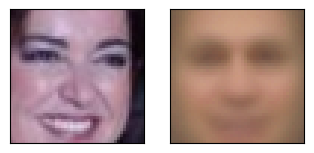

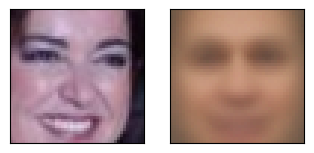

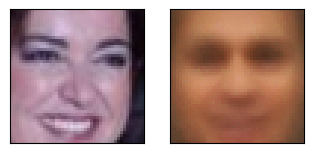

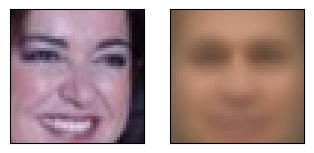

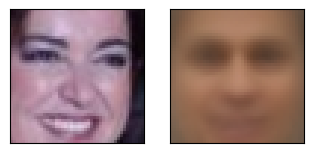

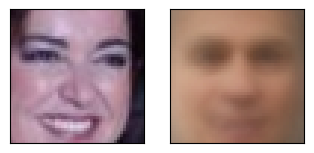

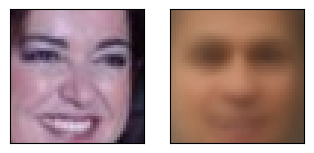

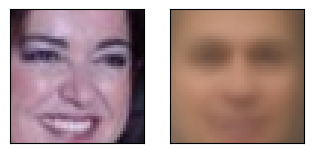

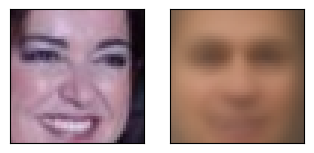

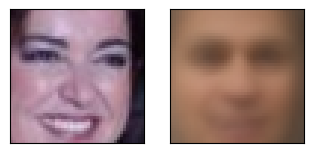

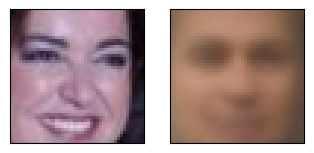

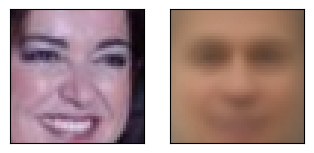

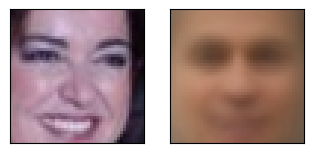

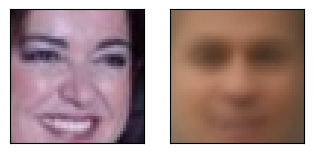

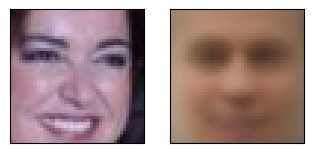

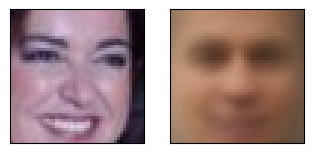

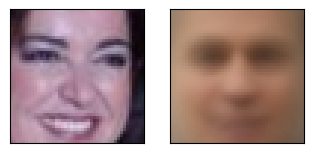

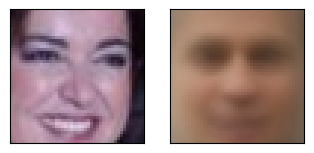

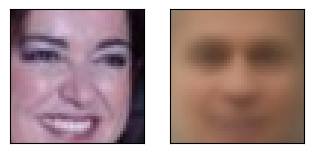

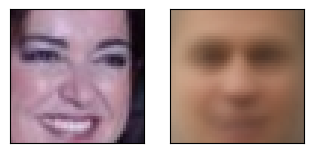

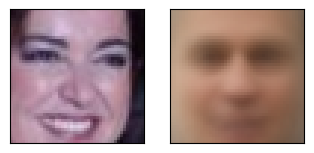

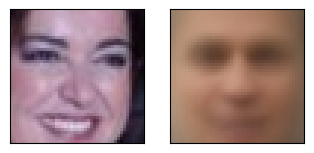

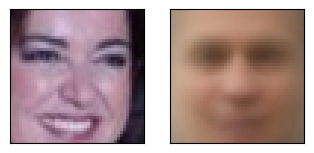

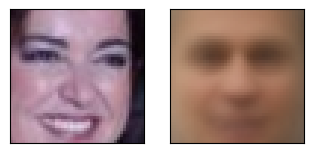

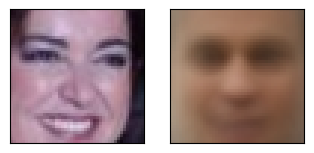

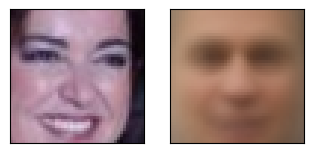

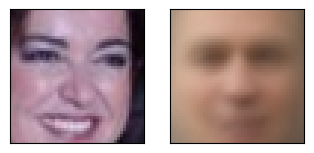

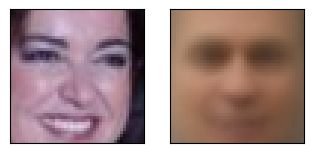

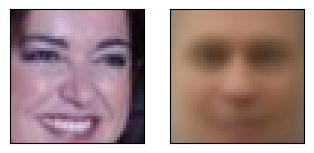

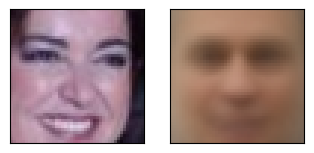

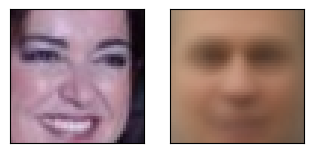

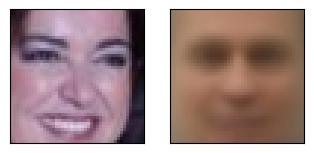

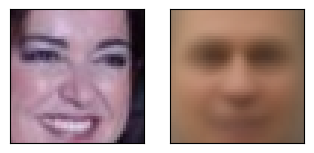

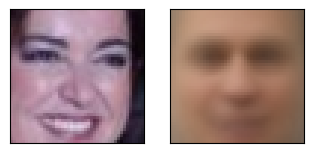

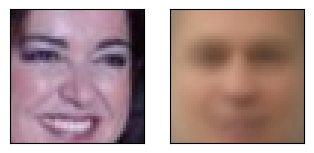

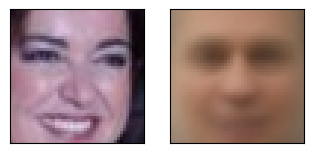

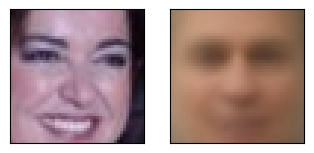

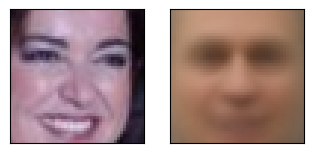

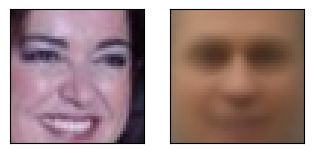

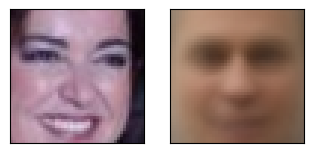

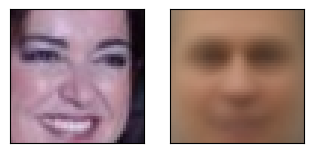

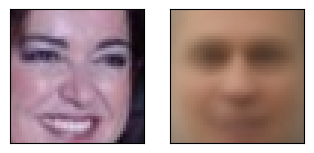

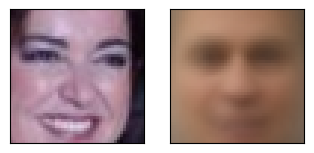

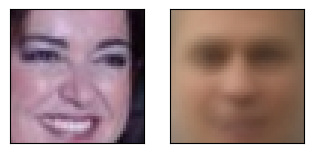

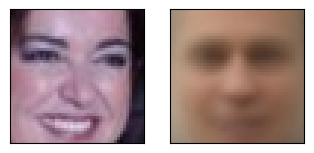

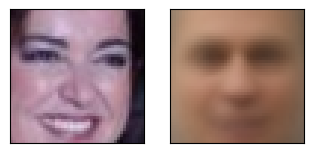

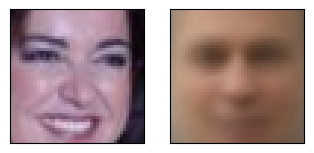

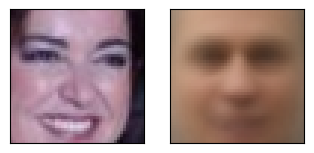

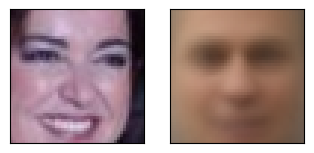

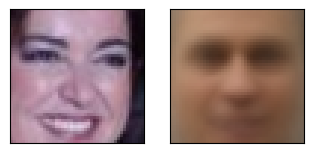

In [29]:
history_vae = train_vae(X_train, X_val, model_vae, epochs=50, batch_size=128, lr=0.001)

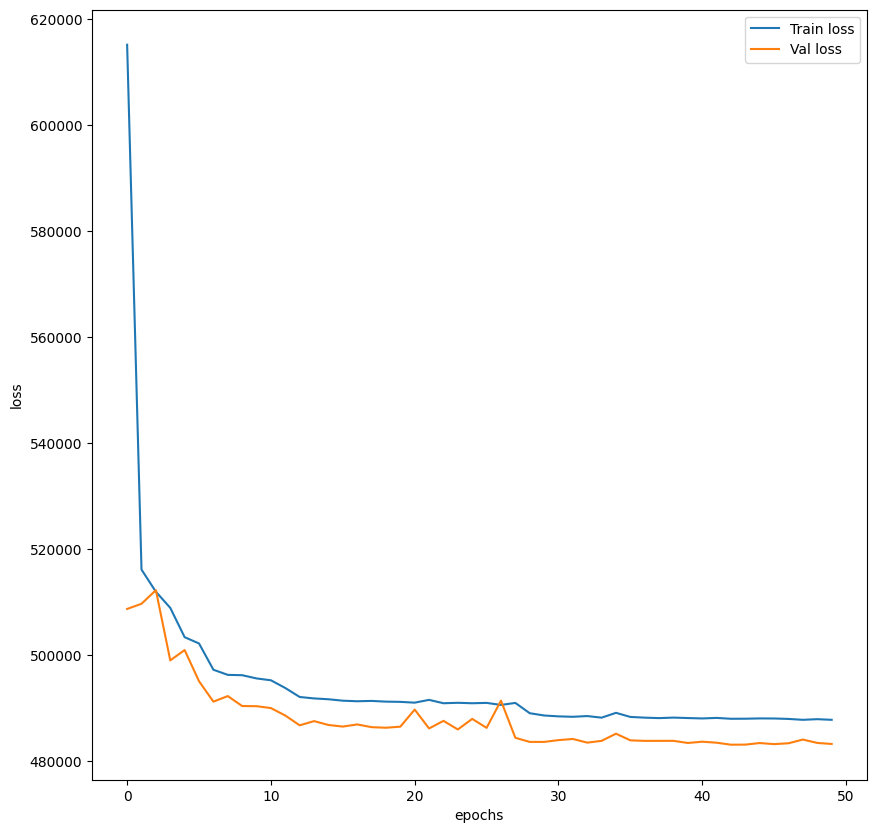

In [30]:
train_loss, val_loss = zip(*history_vae)
plt.figure(figsize=(10,10))
plt.plot(train_loss, label='Train loss')
plt.plot(val_loss, label='Val loss')
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.plot();

# Let's shave someone

In [19]:
def to_latent(pic, model):
    with torch.no_grad():
        inputs = torch.FloatTensor(pic.reshape(-1, 45*45*3))
        inputs = inputs.to(DEVICE)
        model.eval()
        output = model.encode(inputs)
        return output

def from_latent(vec, model):
    with torch.no_grad():
        inputs = vec.to(DEVICE)
        model.eval()
        output = model.decode(inputs)
        return output

In [31]:
attr_beard, data_beard, ids_beard = data_preparation(beard = True)
data_beard = np.array(data_beard/ 255, dtype='float32')
data_beard = torch.FloatTensor(data_beard)
attr_not_beard, data_not_beard, ids_not_beard = data_preparation(not_beard = True)
data_not_beard = np.array(data_not_beard/ 255, dtype='float32')
data_not_beard = torch.FloatTensor(data_not_beard)

beard_latent = to_latent(data_beard, model_vae)[1].mean(axis=0)
no_beard_latent = to_latent(data_not_beard, model_vae)[1].mean(axis=0)
shave_vec = no_beard_latent-beard_latent

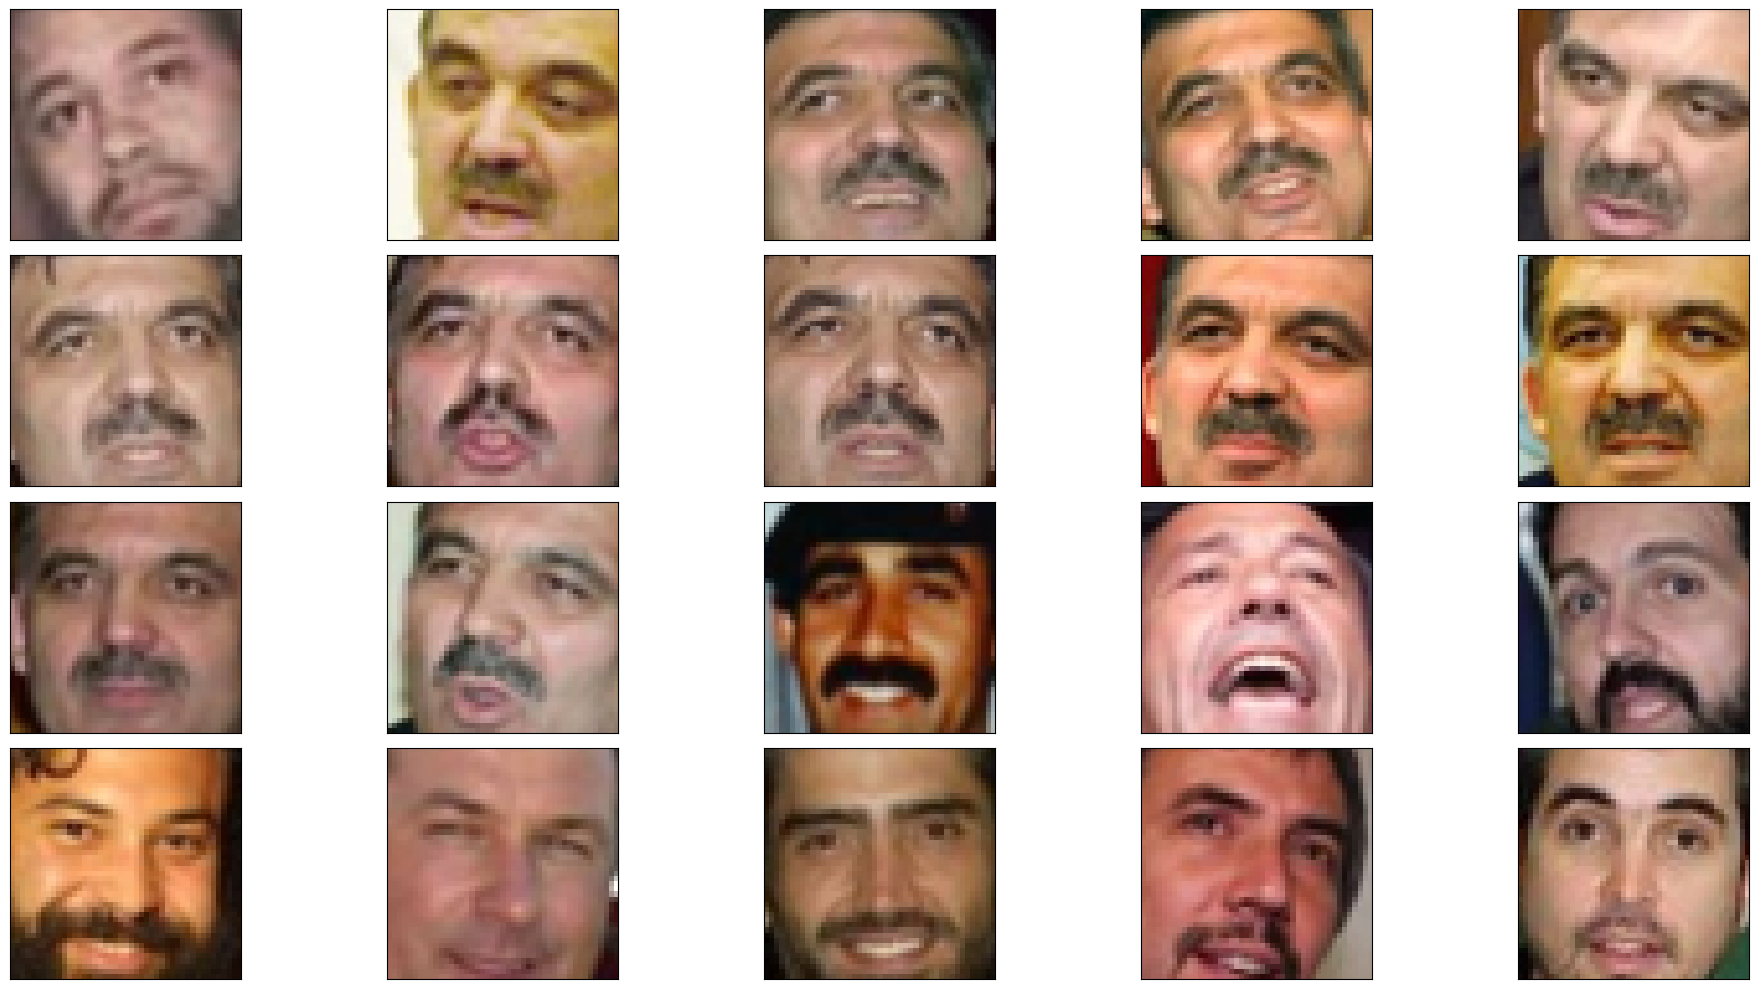

In [21]:
#Checking if the people are smiling men with beard or mustache
plt.figure(figsize=(20,10))
for i in range(0, 20):
    plt.subplot(4, 5, i+1)
    plt.imshow(data_beard[i])
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

In [22]:
def shave_me(ids, model):
    for id in ids:
        pic = data[id:id+1]
        latent_vec = to_latent(pic, model)[0]
        latent_vec[0] += shave_vec
        pic_output = from_latent(latent_vec, model)
        pic_output = pic_output.view(-1,45,45,3).cpu()
        plot_gallery([pic,pic_output], IMAGE_H, IMAGE_W, n_row=1, n_col=2)

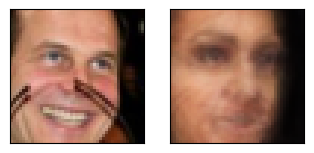

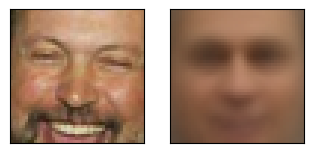

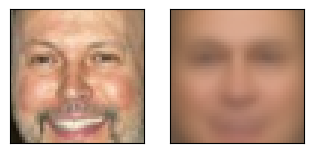

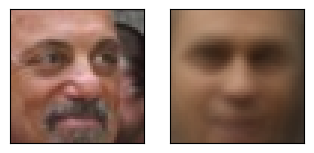

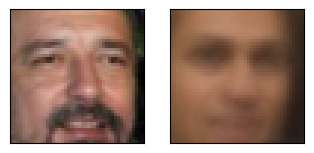

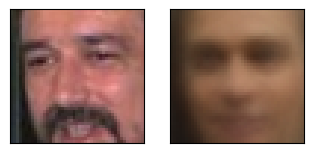

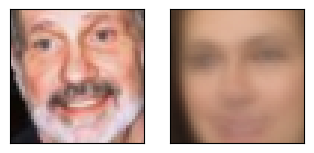

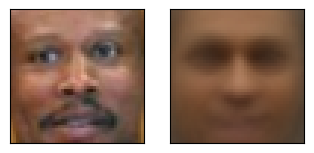

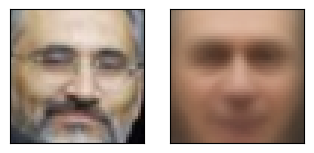

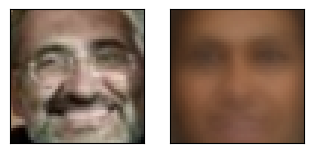

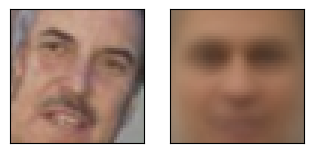

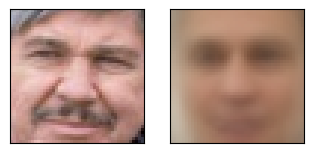

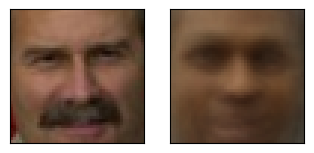

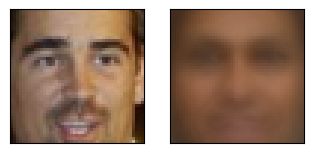

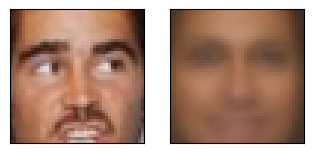

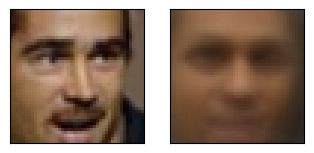

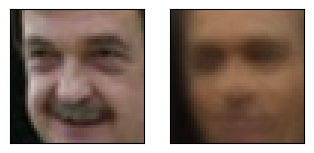

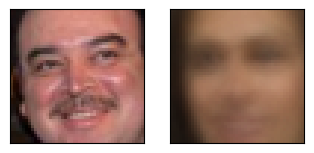

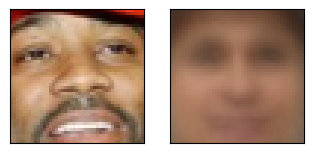

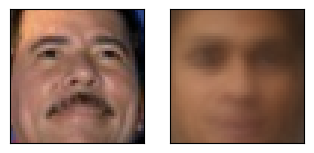

In [40]:
shave_me(ids_beard[30:50], model_vae)

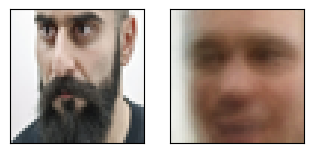

In [52]:
img = plt.imread('2.jpg')[80:-80,80:-80]
img=np.array(Image.fromarray(img).resize([45,45]))
img=np.array(img / 255, dtype='float32')
latent_vec = to_latent(img, model_vae)[0]
latent_vec[0] += shave_vec
pic_output = from_latent(latent_vec, model_vae)
pic_output = pic_output.view(-1,45,45,3).cpu()
plot_gallery([img,pic_output], IMAGE_H, IMAGE_W, n_row=1, n_col=2)